# Final Project 
### Is There a Linear Connection Between Immigration and Unemployment Rate?

##### Shiraz Yaacob, Noa Moshe
##### shiraz.yaacob@gmail.com, noa.moshe95@gmail.com

#### video: https://youtu.be/VOqXdBpVRK4

Many things have been said about imigration- most of them are negative. Along the years politicians implied that there is a strong connection between immigrantion rate and unemployment rate, using this issue to justify surtain economic policy, illigal cross bordering enforcement and more.

We would like to look into this assumption, and check the correlation between those rates.

As we wrote our proposal, we believe that the higher the imigration rate, the higher the unemployment of US citizens will be. After a hard work of pre-processing and plotting our data, we started to think differently. 

We are welcoming you to dive in to our work!

In [1]:
import pandas as pd
from datetime import datetime
import json
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Data Preprocessing

We will use two datasets- US border crossing, and US monthly unemployment rate. 
The US border crossing dataset has a monthly record which includes the amount of people that have crossed the border (US-Canada or US-Mexico), Port name and ID, and Type of Transportation. The US monthly Unemployment Rate is taken from the U.S. Bureau of Labor Statistics, and can be partitioned by State and County.


The US monthly unemployment rate by state is from the US Department of Labor's Bureau of Labor Statistics.

https://www.kaggle.com/jayrav13/unemployment-by-county-us

The US border crossing is from the Bureau of Transportation Statistics of the US.

https://www.kaggle.com/divyansh22/us-border-crossing-data

In [38]:
#downloading out data
import wget
import os
from zipfile import ZipFile

#The Unemployment Rate Data

url = "https://raw.github.com/noayesa/pythonFinal/master/Unemployment_Rate_Data.zip"
wget.download(url, 'Unemployment_Rate_Data.zip')

with ZipFile('Unemployment_Rate_Data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()    

100% [..........................................................................] 6538541 / 6538541

In [39]:
df_unemployment = pd.read_csv('Unemployment_Rate_Data.csv')
df_unemployment.head()

,Year,Month,State,County,Rate
0,2015,February,Mississippi,Newton County,6.1
1,2015,February,Mississippi,Panola County,9.4
2,2015,February,Mississippi,Monroe County,7.9
3,2015,February,Mississippi,Hinds County,6.1
4,2015,February,Mississippi,Kemper County,10.6


In [40]:
#the Border Crossing Data Set

urlfile="https://raw.githubusercontent.com/noayesa/pythonFinal/master/Border_Crossing_Entry_Data.csv"

df_border_crossing = pd.read_csv(urlfile)

In [41]:
df_border_crossing.head()

,Port Name,State,Port Code,Border,Date,Measure,Value
0,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicle Passengers,1414
1,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicles,763
2,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Empty,412
3,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Full,122
4,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Trucks,545


In [42]:
state_names_abb = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District Of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

First, we wolud like to have at each df a column of 'Time'. This column aggregate the 'Year' and 'Month' along with fictive day- the first day of the month. we will use datetime as we've seen at class.

In [44]:
#applying lambda function over each element at the series and convert to datetime
df_border_crossing['Time'] = df_border_crossing.Date.apply(lambda str_date: 
                                                           datetime.strptime(str_date, "%m/%d/%Y %H:%M"))
df_unemployment['Time'] = (df_unemployment.Year.apply(str) + " " 
                           + df_unemployment.Month).apply(lambda str_date: 
                                                          datetime.strptime(str_date, "%Y %B"))

At Border Crossing dataframe we would use the full state name, and not the abbreviation. We will use json file as a dictionary, and translate:

In [45]:
with open('data/states_hash.json') as f:
    state_names_abb = json.load(f)

df_border_crossing.State = df_border_crossing.State.apply(lambda state_name: state_names_abb[state_name])

We would remove redundant columns from each dataframe:

In [46]:
df_border_crossing.drop(columns=['Date', 'Port Name', 'Port Code', 'Measure'], inplace=True)
df_unemployment.drop(columns=['Year', 'Month', 'County'], inplace=True)

At Unemployment Rate df, after adding the 'Time' column, we will group by 'State' and 'Time'. Then we will average the Rate of each state, insted of investigating individual county. 

At Border Crossing df, we will aggregate by 'State', 'Time' and 'Border', to keep the Border column of each border state. We will sum the cross border data for each state, ignoring the 'Measure' (the transportasion method).

In [47]:
df_border_crossing = df_border_crossing.groupby(['State','Border', 'Time'], as_index=False).agg({'Value':'sum'})
df_unemployment = df_unemployment.groupby(['State', 'Time'], as_index=False).mean()

In [48]:
df_unemployment.head()

,State,Time,Rate
0,Alabama,1990-01-01,8.692537
1,Alabama,1990-02-01,8.971642
2,Alabama,1990-03-01,8.408955
3,Alabama,1990-04-01,7.488060
4,Alabama,1990-05-01,7.343284


In [49]:
df_border_crossing.head()

,State,Border,Time,Value
0,Alaska,US-Canada Border,1996-01-01,7705
1,Alaska,US-Canada Border,1996-02-01,7585
2,Alaska,US-Canada Border,1996-03-01,12710
3,Alaska,US-Canada Border,1996-04-01,19454
4,Alaska,US-Canada Border,1996-05-01,48239


Lastly, we will merge both dataframes using 'State' and 'Time' columns.
This will give use a dataframe of every border state at USA, with its Unemployment Rate, and estimated amount of immigrants- both by month. 

In [50]:
merged_df = df_border_crossing.merge(df_unemployment, on=['State','Time'])

merged_df.head()

,State,Border,Time,Value,Rate
0,Arizona,US-Mexico Border,1996-01-01,3377293,12.160000
1,Arizona,US-Mexico Border,1996-02-01,3107925,11.013333
2,Arizona,US-Mexico Border,1996-03-01,3440829,11.040000
3,Arizona,US-Mexico Border,1996-04-01,3284338,10.980000
4,Arizona,US-Mexico Border,1996-05-01,3303278,10.933333


At this point, we ran some tests. We wanted to make sure our data was parsed properly, and the merged_df is what we expected. Here are few of them:

In [51]:
# make sure that all states are border states
print("Amount of non-border states: ", merged_df['Border'].isnull().sum())

# # look for any NaN values- there should be none
print("Are there any NaN values? ", merged_df.isnull().values.any())

# get the list of the states bordering with Mexico
print("List of states bordering with Mexico: \n", merged_df.loc[merged_df.Border == 'US-Mexico Border'].State.unique())

# get the list of the states bordering with Canada
print("list of states bordering with Canada: \n", merged_df.loc[merged_df.Border == 'US-Canada Border'].State.unique())

Amount of non-border states:  0
Are there any NaN values?  False
List of states bordering with Mexico: 
 ['Arizona' 'California' 'New Mexico' 'Texas']
list of states bordering with Canada: 
 ['Idaho' 'Maine' 'Michigan' 'Minnesota' 'Montana' 'New York'
 'North Dakota' 'Vermont' 'Washington']


At this point we've noticed that tere are some missing states at the Canada list. 
The missing state are Pennsylvania, Alaska, New Hampshire and Ohio. 

Looking at the data, we saw that two of the missing states aren't in our Border_Crossing_Entry_Data.csv- 
Pennsylvania and New Hampshire. 

For Alaska, we noticed its missing from the Unemployment Rate dataset.

As for Ohio, the only date we have data on is after 2016, which is the last date of data at the Unemployment Rate dataset: 

In [52]:
df_test_bc = pd.read_csv('data/Border_Crossing_Entry_Data.csv')
print("List of the original states bordering with Canada before processing: \n", 
      df_test_bc.loc[df_test_bc.Border == 'US-Canada Border'].State.unique())

df_test_ur = pd.read_csv('data/Unemployment_Rate_Data.csv')
print("Display df with data of Alaska and make sure there are none: \n")
display(df_test_ur.loc[df_test_ur.State == 'Alaska'])


print("Make sure the dates of Ohio's data are after 2016, which is our last date: \n") 
display(df_test_bc[df_test_bc.State == 'OH'])

List of the original states bordering with Canada before processing: 
 ['AK' 'NY' 'MI' 'ND' 'MN' 'VT' 'WA' 'ME' 'MT' 'ID' 'OH']
Display df with data of Alaska and make sure there are none: 



,Year,Month,State,County,Rate


Make sure the dates of Ohio's data are after 2016, which is our last date: 



,Port Name,State,Port Code,Border,Date,Measure,Value
4646,Toledo-Sandusky,OH,4105,US-Canada Border,9/1/2019 00:00,Personal Vehicles,7
5460,Toledo-Sandusky,OH,4105,US-Canada Border,8/1/2019 00:00,Personal Vehicles,79
6265,Toledo-Sandusky,OH,4105,US-Canada Border,7/1/2019 00:00,Personal Vehicles,115
6604,Toledo-Sandusky,OH,4105,US-Canada Border,6/1/2019 00:00,Personal Vehicles,22
7743,Toledo-Sandusky,OH,4105,US-Canada Border,5/1/2019 00:00,Personal Vehicles,11
14045,Toledo-Sandusky,OH,4105,US-Canada Border,9/1/2018 00:00,Personal Vehicles,33
14857,Toledo-Sandusky,OH,4105,US-Canada Border,8/1/2018 00:00,Personal Vehicles,122
15850,Toledo-Sandusky,OH,4105,US-Canada Border,7/1/2018 00:00,Personal Vehicles,111
16072,Toledo-Sandusky,OH,4105,US-Canada Border,6/1/2018 00:00,Personal Vehicles,90
17049,Toledo-Sandusky,OH,4105,US-Canada Border,5/1/2018 00:00,Personal Vehicles,17


## Part 2: Linear Regression

As we wrote at our proposal, we decided to implement Linear Regression by ourselves. 
We will try to find a linear connection between the Immigration (our X) and the Unemployment Rate (our y).

As we did in lectures, we would like to start by observe the data before calculations.

Text(0.5, 1.0, 'No. of Immigrants vs. Unemployment Rate')

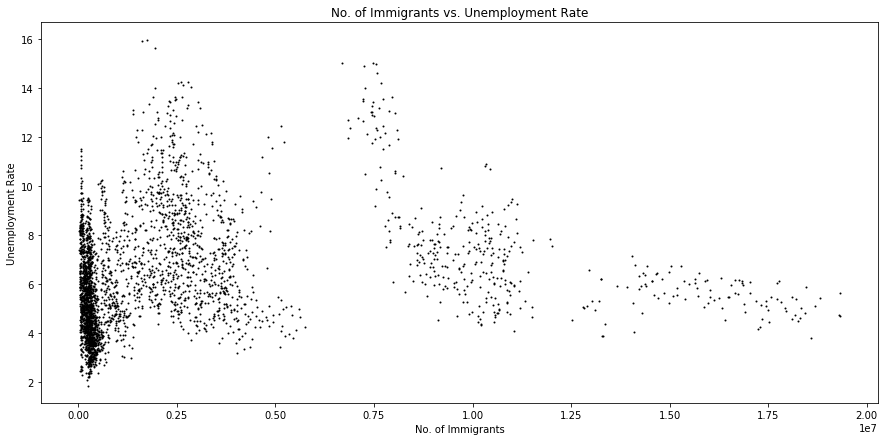

In [53]:
X = merged_df.Value.values
y = merged_df.Rate.values

plt.figure(figsize=(15, 7))
plt.plot(X, y, 'ro', ms=1, mec='k')
plt.ylabel('Unemployment Rate')
plt.xlabel('No. of Immigrants')
plt.title('No. of Immigrants vs. Unemployment Rate')

At first glance, it seems that there are no significant linear conection between these two aspects- this is different from our hypothesis. Yet, we already put a lot of effort in preprocessing and testing, and we will continue with our plan with optimistic approach.



We will start with perform mean normalization on Immigration (our feature), and add vector of ones.

We also perform a standardization around 0 on Unemployment Rate (our true label).

In [54]:
X = (X - np.mean(X, axis=0))/(X.max(axis=0) - X.min(axis=0))
y = (y - np.mean(y)) / (y.max() - y.min())

X = np.vstack((np.ones(X.size), X)).transpose()

We will write two functions that will be used in our main loop. Our main loop will be to compute the current loss, and update the slope (𝜃 or a in litrature) of the line as we go. 

**compute_cost** is responsible to computes the average squared difference between the current predicted values (by using the slop) and the actual true lable.
**gradient_descent** is learning the parameters of the linear model using gradient descent by minimize loss function. This is done by iteratively moving in the direction of descent as defined by the negative of the gradient.

In [55]:
def compute_cost(X, y, 𝜃):
    y = np.reshape(y, len(y)) # for y_hat - y
    y_hat = np.dot(X, 𝜃)
    sqr_diff = np.square(y_hat - y)
    curr_cost = np.sum(sqr_diff)/float(2 * y.size)
    return curr_cost

In [56]:
def gradient_descent(X, y, 𝜃, η, iterations, epsilon):
    cost_history = [] 
    
    for i in range(iterations):
        cost_history.append(compute_cost(X, y, 𝜃))
        
        # Check if the improvement is less than the epsilon
        # This cannot be checked at the first loop
        if i != 0 and (cost_history[i-1] - cost_history[i]) < epsilon:
            break; 
        base_calc = np.subtract(np.matmul(X, 𝜃), y)
        𝜃 = 𝜃 - (η * np.matmul(X.transpose(), base_calc)) / y.size

    return 𝜃, cost_history

We decided to check few learning rate, and choose the most propriate- dependes on the loss. We will do it by iterate over different values of learning rate, and maintain dictionary with it as key and final loss as the value.

In [57]:
ηs = [0.00001, 0.001, 0.01, 0.1, 1, 2, 3]
η_dict = {}
𝜃 = np.ones(X.shape[1])   #vector of 1's as initial value
iterations = 40000
epsilon = 1e-8

In [58]:
for η in ηs:
    𝜃, cost_history = gradient_descent(X, y, 𝜃, η, iterations, epsilon)
    η_dict[η] = cost_history[-1]  # -1 for choosing the last index

best_η = min(η_dict, key=η_dict.get)
best_η

3

After calculating the best learning rate, we will finally run gradient_descent along with the right hyper parameter:

In [59]:
𝜃, cost_history = gradient_descent(X, y, 𝜃, best_η, iterations, epsilon)

In [60]:
𝜃

array([1.53751612e-16, 1.47853184e-01])

Let's plot our model!

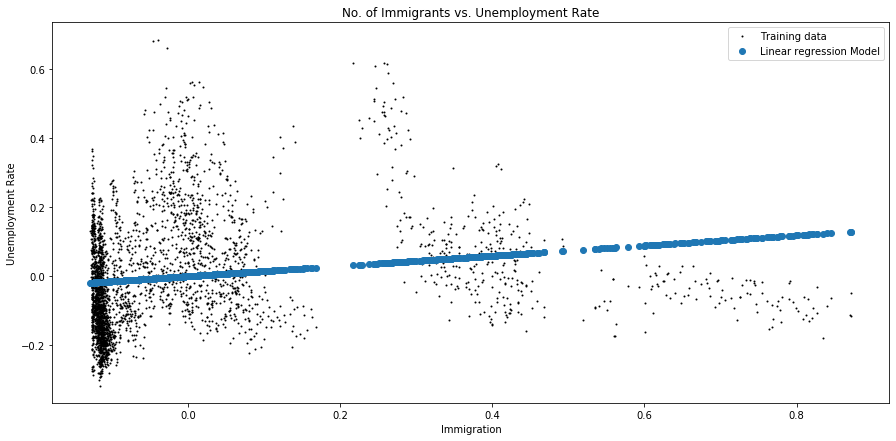

In [61]:
plt.figure(figsize=(15, 7))
plt.plot(X[:,1], y, 'ro', ms=1, mec='k')
plt.ylabel('Unemployment Rate')
plt.xlabel('Immigration')
plt.title('No. of Immigrants vs. Unemployment Rate')
plt.plot(X[:, 1], np.dot(X, 𝜃), 'o')

plt.legend(['Training data', 'Linear regression Model']);

We can also use seaborn to plot as we've seen at class:

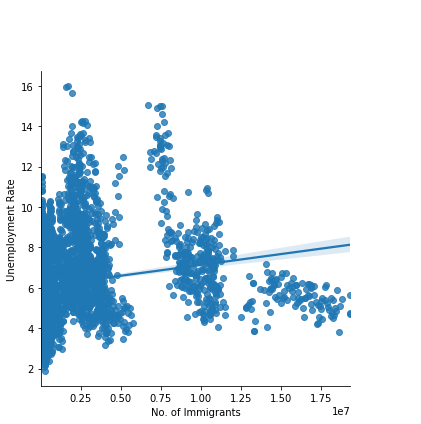

In [62]:
merged_df.rename(columns={"Value": "No. of Immigrants", "Rate": "Unemployment Rate"}, inplace = True)
data = merged_df[['No. of Immigrants', 'Unemployment Rate']]

linear_model_plot = sns.JointGrid(x="No. of Immigrants", y="Unemployment Rate", data=data)
linear_model_plot.plot_joint(sns.regplot)
linear_model_plot.ax_marg_x.set_axis_off()
linear_model_plot.ax_marg_y.set_axis_off()

## Linear Regression for Bordering States with Canada

Let us now seperate our data into states bordering with Canada, and later on with the states bordering Mexico. 
Similarly to before, after seperating the data, we will perform mean normalization and add a vector of ones.

Also, we standarize around 0 for the Unemployment Rate.

In [63]:
X_Canada = merged_df[merged_df.Border == 'US-Canada Border']['No. of Immigrants'].values
y_Canada = merged_df[merged_df.Border == 'US-Canada Border']['Unemployment Rate'].values

#we use axis=0 because X have 2 columns
X_Canada = (X_Canada - np.mean(X_Canada, axis=0))/(X_Canada.max(axis=0) - X_Canada.min(axis=0))     
y_Canada = (y_Canada - np.mean(y_Canada)) / (y_Canada.max() - y_Canada.min())

X_Canada = np.vstack((np.ones(X_Canada.size), X_Canada)).transpose()

Finding the best learning rate:

In [64]:
#finding Best η- the learning rate
ηs = [0.00001, 0.001, 0.01, 0.1, 1, 2, 3]
η_dict = {}
slope_Canada = np.ones(X_Canada.shape[1])   #vector of 1's, for X*slope in gradient_descent
iterations = 40000
        
for η in ηs:
    slope_Canada, cost_history = gradient_descent(X_Canada, y_Canada, slope_Canada, η, iterations, epsilon)
    η_dict[η] = cost_history[-1]  # -1 for choosing the last index

    best_η = min(η_dict, key=η_dict.get)  

best_η

3

In [65]:
slope_Canada, cost_history = gradient_descent(X, y, slope_Canada, best_η, iterations, epsilon)

In [66]:
slope_Canada

array([5.67020150e-08, 1.47965849e-01])

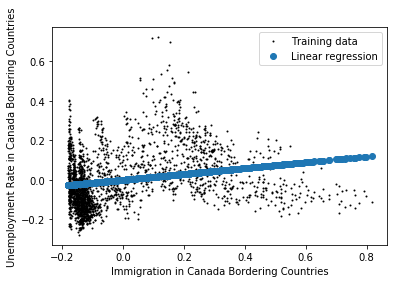

In [67]:
#plotting
plt.plot(X_Canada[:,1], y_Canada, 'ro', ms=1, mec='k')
plt.ylabel('Unemployment Rate in Canada Bordering Countries')
plt.xlabel('Immigration in Canada Bordering Countries')
plt.plot(X_Canada[:, 1], np.dot(X_Canada, slope_Canada), 'o')

plt.legend(['Training data', 'Linear regression']);

We can conclude from the above graph that there is a **small positive correlation** between the immigration from Canada and the unemployment rate. 
However, as the slope is 0.147965849, it suggests that there is a very low correlation between the two.

## Linear Regression for Bordering States with Mexico

Lastly, we will look at the countries bordering with Mexico:

In [68]:
X_Mexico = merged_df[merged_df.Border == 'US-Mexico Border']['No. of Immigrants'].values
y_Mexico = merged_df[merged_df.Border == 'US-Mexico Border']['Unemployment Rate'].values
 
#we use axis=0 because X have 2 columns
X_Mexico = (X_Mexico - np.mean(X_Mexico, axis=0))/(X_Mexico.max(axis=0) - X_Mexico.min(axis=0))     
y_Mexico = (y_Mexico - np.mean(y_Mexico)) / (y_Mexico.max() - y_Mexico.min())

X_Mexico = np.vstack((np.ones(X_Mexico.size), X_Mexico)).transpose()

In [69]:
#finding Best η- the learning rate
ηs = [0.00001, 0.001, 0.01, 0.1, 1, 2, 3]
η_dict = {}
slope_Mexico = np.ones(X_Mexico.shape[1])   #vector of 1's, for X*slope in gradient_descent
iterations = 40000
        
for η in ηs:
    slope_Mexico, cost_history = gradient_descent(X_Mexico, y_Mexico, slope_Mexico, η, iterations, epsilon)
    η_dict[η] = cost_history[-1]  # -1 for choosing the last index

    best_η = min(η_dict, key=η_dict.get) 
    
best_η

3

In [70]:
slope_Mexico, cost_history = gradient_descent(X, y, slope_Mexico, best_η, iterations, epsilon)

In [71]:
slope_Mexico

array([-0.00035296,  0.14449988])

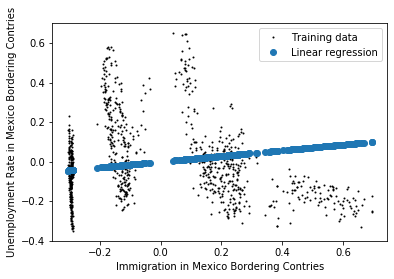

In [72]:
#plotting
plt.plot(X_Mexico[:,1], y_Mexico, 'ro', ms=1, mec='k')
plt.ylabel('Unemployment Rate in Mexico Bordering Contries')
plt.xlabel('Immigration in Mexico Bordering Contries')
plt.plot(X_Mexico[:, 1], np.dot(X_Mexico, slope_Mexico), 'o')

plt.legend(['Training data', 'Linear regression']);

Likewise, the immigration from Mexico and the unemployment rate have a **positive correlation** as predicted with Canada. The slope is ~0.145. 

Suprisingly, the correlation is actually lower than the one of Immegration from Canada and the unemployment rate in it's bordering countries.